In [64]:
#https://github.com/roboflow/notebooks
#https://www.youtube.com/watch?v=D-D6ZmadzPE

In [65]:
import os
print(os.getcwd())

/home/avishkar/Desktop/projects/panoptic_segmentation


## Install FastSAM + Dependencies

In [66]:
# install FastSAM

%cd "/home/avishkar/Desktop/projects/panoptic_segmentation"

if not os.path.exists("FastSAM"):
    !git clone https://github.com/CASIA-IVA-Lab/FastSAM.git
    !pip3 -q install -r FastSAM/requirements.txt
# install CLIP
!pip3 -q install git+https://github.com/openai/CLIP.git
# install other dependencies
!pip3 -q install roboflow supervision jupyter_bbox_widget

/home/avishkar/Desktop/projects/panoptic_segmentation


## Install weights 

In [67]:
print(os.getcwd())
if not os.path.exists("weights/FastSAM.pt"):
    !mkdir -p weights
    !wget -P weights -q https://huggingface.co/spaces/An-619/FastSAM/resolve/main/weights/FastSAM.pt
FAST_SAM_CHECKPOINT_PATH = f"weights/FastSAM.pt"

/home/avishkar/Desktop/projects/panoptic_segmentation


## Sample data

In [68]:
if len(os.listdir("data")) ==0:
    !mkdir -p data
    !wget -P data -q https://media.roboflow.com/notebooks/examples/dog.jpeg
    !wget -P data -q https://media.roboflow.com/notebooks/examples/robot.jpeg
!ls -lh data

total 6.1M
-rw-rw-r-- 1 avishkar avishkar 104K Jun  2  2023 dog.jpeg
-rw-rw-r-- 1 avishkar avishkar 104K Jun  2  2023 dog.jpeg.1
-rw-rw-r-- 1 avishkar avishkar 426K Jul  5  2023 robot.jpeg
-rw-rw-r-- 1 avishkar avishkar 426K Jul  5  2023 robot.jpeg.1
-rw-rw-r-- 1 avishkar avishkar 2.5M Mar 31 15:50 table_1.jpg
-rw-rw-r-- 1 avishkar avishkar  87K Mar 31 15:52 table_2.jpg
-rw-rw-r-- 1 avishkar avishkar 2.6M Mar 31 18:31 test_vid.mp4


In [69]:
%cd FastSAM

import os
import cv2
import torch
import base64

import supervision as sv
import numpy as np

from fastsam import FastSAM, FastSAMPrompt

# from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

/home/avishkar/Desktop/projects/panoptic_segmentation/FastSAM


## Load FastSAM

In [70]:
%cd ..
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

fast_sam = FastSAM(FAST_SAM_CHECKPOINT_PATH)

/home/avishkar/Desktop/projects/panoptic_segmentation


## FastSAM inference
* `retina_masks=True` determines whether the model uses retina masks for generating segmentation masks.
* `imgsz=1024` sets the input image size to 1024x1024 pixels for processing by the model.
* `conf=0.4` sets the minimum confidence threshold for object detection.
* `iou=0.9` sets the minimum intersection over union threshold for non-maximum suppression to filter out duplicate detections.

In [71]:
IMAGE_PATH = f"data/table_2.jpg"
results = fast_sam(
    source=IMAGE_PATH,
    device=DEVICE,
    retina_masks=True,
    imgsz=1024,
    conf=0.4,
    iou=0.9)
img = cv2.imread(IMAGE_PATH)

print(f"Masks shape: {results[0].masks.shape}")
print(f"Boxes shape: {results[0].boxes.shape}")


prompt_process = FastSAMPrompt(img, results, device=DEVICE)
masks = prompt_process.everything_prompt()
prompt_process.plot(annotations=masks, output_path=f"./output/table_2.jpg")


image 1/1 /home/avishkar/Desktop/projects/panoptic_segmentation/data/table_2.jpg: 768x1024 19 objects, 1942.2ms
Speed: 3.8ms preprocess, 1942.2ms inference, 45.8ms postprocess per image at shape (1, 3, 1024, 1024)


Masks shape: torch.Size([19, 809, 1080])
Boxes shape: torch.Size([19, 6])


In [72]:
#print(results , masks , )

In [73]:
def annotate_image(image_path: str, masks: np.ndarray) -> np.ndarray:
    image = cv2.imread(image_path)

    xyxy = sv.mask_to_xyxy(masks=masks)
    # print(xyxy.shape)
    # print(class_id)
    detections = sv.Detections(xyxy=xyxy, mask=masks)

    mask_annotator = sv.MaskAnnotator(color_lookup = sv.ColorLookup.INDEX)
    return mask_annotator.annotate(scene=image.copy(), detections=detections)

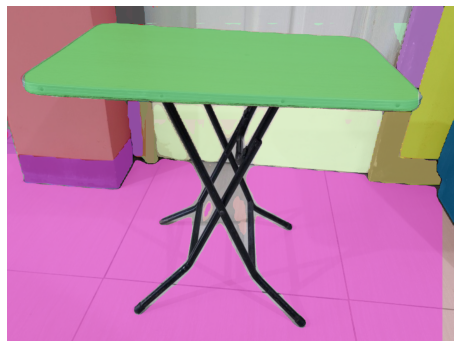

In [74]:
masks = masks.cpu().numpy().astype(bool)
annotated_image=annotate_image(image_path=IMAGE_PATH, masks=masks)
sv.plot_image(image=annotated_image, size=(8, 8))

In [75]:
# print(type(masks))
# print(dir(masks))



print(type(results))
# print(dir(results))
# print(results[0][2])
print(dir(results[0]))

max_ =0
for i in results[0]:
    x,y,w,h =i.boxes.xywh[0]
    # print(i.boxes.xywh)
    # print(type(i))
    # print(x, y, w, h)
    print(f" bounding box area : {w * h}")
    max_ = max(max_, w*h)

print(max_)

<class 'list'>
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_keys', 'boxes', 'cpu', 'cuda', 'keypoints', 'keys', 'masks', 'names', 'new', 'numpy', 'orig_img', 'orig_shape', 'pandas', 'path', 'plot', 'probs', 'save_crop', 'save_dir', 'save_txt', 'speed', 'to', 'tojson', 'update', 'verbose']
 bounding box area : 33201.12109375
 bounding box area : 132726.28125
 bounding box area : 202556.34375
 bounding box area : 48185.6015625
 bounding box area : 10163.66796875
 bounding box area : 38225.69921875
 bounding box area : 79044.8046875
 bounding box area : 11132.2783203125
 bounding box area : 562940.25
 bounding box area : 30978.228515625
 bounding box a

In [76]:
masks_seg = [
    mask['segmentation']
    for mask
    in sorted(results, key=lambda x: x['area'], reverse=True)
]

sv.plot_images_grid(
    images=masks_seg,
    grid_size=(8, int(len(masks) / 8)),
    size=(16, 16)
)

IndexError: too many indices for tensor of dimension 2